In [ ]:
!pip install transformers

     |████████████████████████████████| 2.3MB 7.6MB/s 
     |████████████████████████████████| 901kB 46.2MB/s 
     |████████████████████████████████| 3.3MB 45.9MB/s 


In [ ]:
pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1MB 1.4MB/s eta 0:13:56tcmalloc: large alloc 1147494400 bytes == 0x55dac57de000 @  0x7fcc7b677615 0x55da6049acdc 0x55da6057a52a 0x55da6049dafd 0x55da6058efed 0x55da60511988 0x55da6050c4ae 0x55da6049f3ea 0x55da605117f0 0x55da6050c4ae 0x55da6049f3ea 0x55da6050e32a 0x55da6058fe36 0x55da6050d853 0x55da6058fe36 0x55da6050d853 0x55da6058fe36 0x55da6050d853 0x55da6058fe36 0x55da606123e1 0x55da605726a9 0x55da604ddcc4 0x55da6049e559 0x55da605124f8 0x55da6049f30a 0x55da6050d3b5 0x55da6050c7ad 0x55da6049f3ea 0x55da6050d3b5 0x55da6049f30a 0x55da6050d3b5
     |█████████████████               | 1055.7MB 1.4MB/s eta 0:11:23tcmalloc: large alloc 1434370048 bytes == 0x55da63006000 @  0x7fcc7b677615 0x55da6049acdc 0x55da6057a52a 0x55da6049dafd 0x55da6058efed 0x55da60511988 0x55da6050c4ae 0x55da6049f3ea 0x55da605117f0 0x55da6050c4ae 0x55da6049f3ea 0x55da6050e32a 0x55da6058fe36 0x55da6050d853 0

In [ ]:
!pip install -U torchtext==0.9.0

     |████████████████████████████████| 7.1MB 6.5MB/s 
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator
from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup, RobertaForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

In [ ]:
# Set random seed and set device to GPU.
torch.manual_seed(17)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [ ]:
# Load CSV file with dataset. Perform basic transformations.
df = pd.read_csv('/content/combined_all.csv')
df.fillna('', inplace=True)
encode_label = {'false' : 0, 'true' : 1, 'partially false': 2, 'other': 3}

df['our rating'] = df['our rating'].map(encode_label)
df['titletext'] = df['title'] + ". " + df['text']
df['our rating']

0      0
1      1
2      0
3      0
4      2
      ..
945    3
946    2
947    1
948    0
949    0
Name: our rating, Length: 950, dtype: int64

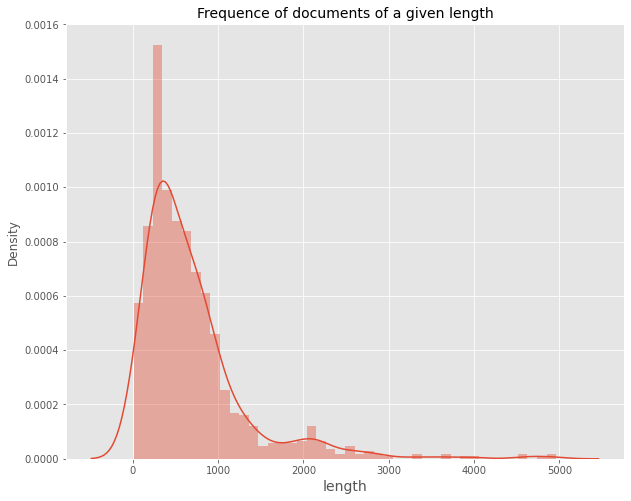

In [ ]:
# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
df['length'] = df['titletext'].apply(lambda x: len(x.split()))
sns.distplot(df[df['length'] < 5000]['length'])
plt.title('Frequence of documents of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)
None

In [ ]:
words = df.copy()

import nltk

from nltk.corpus import stopwords

nltk.download('stopwords')

nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
import re
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
corpus = []

for i in range(len(words)):
    review = re.sub('[^a-zA-Z]', ' ', words['titletext'][i])
    review = review.lower()
    review = review.split()
    review = [lemmatizer.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [ ]:
df['titletext'] = corpus
df

,public_id,title,text,our rating,titletext,length
0,f2182a54,HUGE! Attorney Sidney Powell CONFIRMS Alleged ...,Last week Rep. Louie Gohmert told Chris Salced...,0,huge attorney sidney powell confirms alleged d...,457
1,c5175d8d,Paul Ryan’s Worst Ally - The New York Times,WHATEVER drama plays out when Republicans meet...,1,paul ryan worst ally new york time whatever dr...,281
2,213a870b,"You Can Get Jail Time Or $3,000 Fine For Not W...",Source page URL Title You Can Get Jail Time O...,0,get jail time fine wearing face mask canada st...,46
3,392886ea,Antifa gearing up for false flag violence disg...,With merchants in Democrat-run cities boarding...,0,antifa gearing false flag violence disguised t...,388
4,bc6d5d55,Remarks by President Biden on the Administrati...,State Dining Room 4:22 P.M. EST THE PRESIDEN...,2,remark president biden administration covid va...,2011
...,...,...,...,...,...,...
945,168e5898,NHS fails thousands of new mothers with post-n...,Increased atmospheric carbon dioxide has helpe...,3,nh fails thousand new mother post natal depres...,295
946,94aabd16,Boris Johnson vows to compensate for 'SNP inad...,Boris Johnson has vowed to bring forward measu...,2,boris johnson vow compensate snp inadequacy bo...,186
947,1a6a1a97,Nothing On This Earth Will Make President Buha...,The number of children being considered for ad...,1,nothing earth make president buhari resign may...,650
948,842ac903,,Rep. Leon Young figures the Wisconsin Legislat...,0,rep leon young figure wisconsin legislature al...,513


In [ ]:
df['titletext'] = df['titletext'].apply(lambda x: " ".join(x.split()[:512]))
df.to_csv("/content/prep_news.csv")

In [ ]:
# Initialize tokenizer.
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [ ]:
max_len_roberta = 0

# For every sentence...
for sent in df['titletext'].values:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids_roberta = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len_roberta = max(max_len_roberta, len(input_ids_roberta))


print('Max sentence length RoBERTa: ', max_len_roberta)

Max sentence length RoBERTa:  792


In [ ]:
# Set tokenizer hyperparameters.
MAX_SEQ_LEN = 256
BATCH_SIZE = 32
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)


# Define columns to read.
label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)

fields = {'titletext' : ('titletext', text_field), 'our rating' : ('our rating', label_field)}


# Read preprocessed CSV into TabularDataset and split it into train, test and valid.
train_data, valid_data, test_data = TabularDataset(path="/content/prep_news.csv", 
                                                   format='CSV', 
                                                   fields=fields, 
                                                   skip_header=False).split(split_ratio=[0.70, 0.2, 0.1], 
                                                                            stratified=True, 
                                                                            strata_field='our rating')

# Create train and validation iterators.
train_iter, valid_iter = BucketIterator.splits((train_data, valid_data),
                                               batch_size=BATCH_SIZE,
                                               device=device,
                                               shuffle=True,
                                               sort_key=lambda x: len(x.titletext), 
                                               sort=True, 
                                               sort_within_batch=False)

# Test iterator, no shuffling or sorting required.
test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)


In [ ]:
# Functions for saving and loading model parameters and metrics.
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)

    
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, path)


def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
# Model with extra layers on top of RoBERTa
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base',return_dict=False, num_labels = 4)
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 4)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)
        
        return x

In [ ]:
def pretrain(model, 
             optimizer, 
             train_iter, 
             valid_iter, 
             scheduler = None,
             valid_period = len(train_iter),
             num_epochs = 5):
    
    # Pretrain linear layers, do not train bert
    for param in model.roberta.parameters():
        param.requires_grad = False
    
    model.train()
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0   
    global_step = 0  
    
    # Train loop
    for epoch in range(num_epochs):
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)
            
            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            
            loss = torch.nn.CrossEntropyLoss()
            loss = loss(y_pred, target)
   
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)
                        
                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                
                model.train()

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], PT Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                train_loss = 0.0                
                valid_loss = 0.0
    
    # Set bert parameters back to trainable
    for param in model.roberta.parameters():
        param.requires_grad = True
        
    print('Pre-training done!')

In [ ]:
# Training Function
output_path = '/content'
def train(model,
          optimizer,
          train_iter,
          valid_iter,
          scheduler = None,
          num_epochs = 5,
          valid_period = len(train_iter),
          output_path = output_path):
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    best_valid_loss = float('Inf')
    
    global_step = 0
    global_steps_list = []
    
    model.train()
    
    # Train loop
    for epoch in range(num_epochs):
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)

            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            #output = model(input_ids=source,
            #              labels=target,
            #              attention_mask=mask)
            
            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
            #loss = output[0]
            
            loss.backward()
            
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)

                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        #output = model(input_ids=source,
                        #               labels=target,
                        #               attention_mask=mask)
                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        #loss = output[0]
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                # checkpoint
                if best_valid_loss > valid_loss:
                    best_valid_loss = valid_loss
                    save_checkpoint(output_path + '/model.pkl', model, best_valid_loss)
                    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
                        
                train_loss = 0.0                
                valid_loss = 0.0
                model.train()
    
    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
    print('Training done!')

In [ ]:
# Main training loop
NUM_EPOCHS = 4
steps_per_epoch = len(train_iter)

model = ROBERTAClassifier(0.4)
model = model.to(device)


optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

print("======================= Start pretraining ==============================")


pretrain(model=model,
         train_iter=train_iter,
         valid_iter=valid_iter,
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

NUM_EPOCHS = 8
print("======================= Start training =================================")
optimizer = AdamW(model.parameters(), lr=2e-4, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*2, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

train(model=model, 
      train_iter=train_iter, 
      valid_iter=valid_iter, 
      optimizer=optimizer, 
      scheduler=scheduler, 
      num_epochs=NUM_EPOCHS)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


======================= Start pretraining ==============================
Epoch [1/4], global step [21/84], PT Loss: 1.3621, Val Loss: 1.2581
Epoch [2/4], global step [42/84], PT Loss: 1.2688, Val Loss: 1.2146
Epoch [3/4], global step [63/84], PT Loss: 1.2501, Val Loss: 1.2065
Epoch [4/4], global step [84/84], PT Loss: 1.2456, Val Loss: 1.2052
Pre-training done!
======================= Start training =================================
Epoch [1/8], global step [21/168], Train Loss: 1.2233, Valid Loss: 1.1925
Epoch [2/8], global step [42/168], Train Loss: 1.2219, Valid Loss: 1.1823
Epoch [3/8], global step [63/168], Train Loss: 1.2231, Valid Loss: 1.1401
Epoch [4/8], global step [84/168], Train Loss: 1.1289, Valid Loss: 1.0130
Epoch [5/8], global step [105/168], Train Loss: 1.0531, Valid Loss: 0.9620
Epoch [6/8], global step [126/168], Train Loss: 0.9567, Valid Loss: 0.9782
Epoch [7/8], global step [147/168], Train Loss: 0.9079, Valid Loss: 0.9783
Epoch [8/8], global step [168/168], Train 

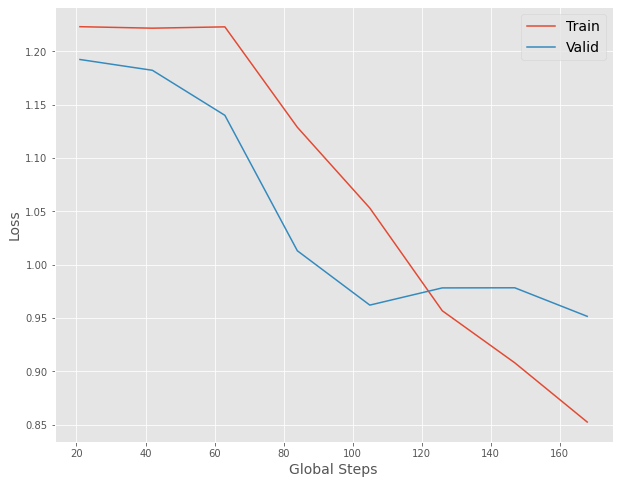

In [ ]:
plt.figure(figsize=(10, 8))
train_loss_list, valid_loss_list, global_steps_list = load_metrics(output_path + '/metric.pkl')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [ ]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (source, target), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, attention_mask=mask)

                y_pred.extend(torch.argmax(output, axis=-1).tolist())
                y_true.extend(target.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred, labels=[3,2,1,0])
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['other', 'partially false', 'true', 'false'])
    ax.yaxis.set_ticklabels(['other', 'partially false', 'true', 'false'])

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.85      0.74        97
           1       0.35      0.20      0.26        30
           2       0.50      0.49      0.49        47
           3       0.00      0.00      0.00        15

    accuracy                           0.59       189
   macro avg       0.38      0.38      0.37       189
weighted avg       0.51      0.59      0.54       189



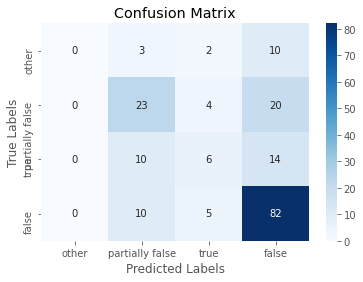

In [ ]:
load_checkpoint(output_path + '/model.pkl', model)

evaluate(model, test_iter)

In [ ]:
test = pd.read_csv('/content/Task3a_testing.csv')
test.fillna('', inplace=True)
test['titletext'] = test['title'] + '. ' + test['text']
test

,public_id,text,title,our rating,titletext
0,81a67c96,Former state House Majority Leader Adam Hasner...,- The Washington Post,,- The Washington Post. Former state House Majo...
1,6e5ec6fb,"Editor’s note: Subsequent to this article, VTD...",Rubio Comments on Iran Nuclear Deal,,Rubio Comments on Iran Nuclear Deal. Editor’s ...
2,d9cd4895,The hypocritical Lib Dems want to ignore the r...,Climate Alarmists Caught Manipulating Temperat...,,Climate Alarmists Caught Manipulating Temperat...
3,4a1a9b9f,Urgent action to boost the number of children ...,Who are the arsonists setting rural fires in W...,,Who are the arsonists setting rural fires in W...
4,6d16fa40,By Ken Allen AFSCME Council 75 represents the ...,"Diabetes prescriptions now cost NHS £1bn, figu...",,"Diabetes prescriptions now cost NHS £1bn, figu..."
...,...,...,...,...,...
359,3d1a155a,"There is nothing we can do about it, except to...","The Sea Is Rising, but Not Because of Climate ...",,"The Sea Is Rising, but Not Because of Climate ..."
360,6c425155,Increased atmospheric carbon dioxide has helpe...,The Phony War Against CO2\n,,The Phony War Against CO2\n. Increased atmosph...
361,f0669fad,Considering the importance of immunity boostin...,"Government of India Ministry of Ayurveda, Yoga...",,"Government of India Ministry of Ayurveda, Yoga..."
362,8060b507,"Even if world temperatures rise, the appropria...",Climate Change Isn’t the End of the World,,Climate Change Isn’t the End of the World. Eve...


In [ ]:
words_test = test.copy()
corpus_test = []

lemmatizer = WordNetLemmatizer()

for i in range(len(words_test)):
    review_test = re.sub('[^a-zA-Z]', ' ', words_test['titletext'].iloc[i])
    review_test = review_test.lower()
    review_test = review_test.split()
    review_test = [word for word in review_test if not word in stopwords.words('english')]
    review_test = ' '.join(review_test)
    corpus_test.append(review_test)

In [ ]:
test['titletext'] = corpus_test

test['titletext'] = test['titletext'].apply(lambda x: " ".join(x.split()[:512]))
test.to_csv('/content/test_data.csv')

In [ ]:
sentences = test['titletext'].values

In [ ]:
print(model.state_dict())
labels = ['false', 'true', 'partially false', 'other']
model = ROBERTAClassifier()
model.load_state_dict(torch.load('/content/model_state.pt'))
model = model.to(device)

labels_output = []

# For every sentence...
for sent in sentences:

    roberta_encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    roberta_encoded_dict = roberta_encoded_dict.to(device)
    outputs = model(**roberta_encoded_dict)
    labels_output.append(labels[outputs.argmax()])

labels_output

In [ ]:
test_out = pd.DataFrame()
test_out['public_id'] = test['public_id']
test_out['predicted_rating'] = labels_output
test_out


,public_id,predicted_rating
0,81a67c96,partially false
1,6e5ec6fb,false
2,d9cd4895,false
3,4a1a9b9f,true
4,6d16fa40,partially false
...,...,...
359,3d1a155a,false
360,6c425155,false
361,f0669fad,false
362,8060b507,false


In [ ]:
test_out.to_csv('/content/predictions.csv', index = False)